# Benchmarking GFLOPS with pywren and lambda


In [2]:
%pylab inline
import numpy as np
import time
import flops_benchmark
import pandas as pd
import pickle
import seaborn as sns
sns.set_style('whitegrid')


Populating the interactive namespace from numpy and matplotlib


# Getting Started 

We are going to benchmark the simple function below, which simply generates two matrices and computes their matrix (dot) product. The matrices are of size `MAT_N` and we will compute the product `loopcount` times. 

In [2]:

def compute_flops(loopcount, MAT_N):
    
    A = np.arange(MAT_N**2, dtype=np.float64).reshape(MAT_N, MAT_N)
    B = np.arange(MAT_N**2, dtype=np.float64).reshape(MAT_N, MAT_N)

    t1 = time.time()
    for i in range(loopcount):
        c = np.sum(np.dot(A, B))

    FLOPS = 2 *  MAT_N**3 * loopcount
    t2 = time.time()
    return FLOPS / (t2-t1)



All of the actual benchmark code is in a stand-alone python file, which you can call as follows. It places the output in `small.pickle`

In [3]:
!python flops_benchmark.py --workers=10 --loopcount=10 --matn=1024 --outfile="small.pickle"

invocation done, dur= 5.186460971832275
callset id:  49269cbe-f70f-4b4a-be6e-bad7188438cb
total time 11.238720893859863
19.10790087485179 GFLOPS


We can plot a histogram of the results: 

In [4]:
exp_results = pickle.load(open("small.pickle", 'rb'))
results_df = flops_benchmark.results_to_dataframe(exp_results)


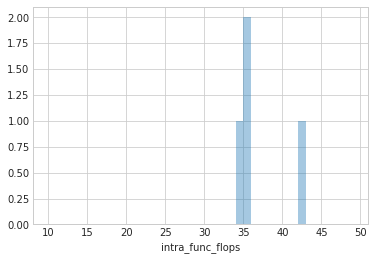

In [8]:
sns.distplot(results_df.intra_func_flops/1e9, bins=np.arange(10, 50), kde=False)

# scaling up
Now we will run a very large number of lambdas simultaneously. Note that this is very dependent on the maximum number of simultaneous lambdas that AWS has enabled for your account. You can e-mail them and ask for a limit increase. Note that due to stragglers this can also take a while

In [22]:
# My account has a lambda limit of 3000 simultaneous lambdas, so I'm using 2800 to give us some headroom
!python flops_benchmark.py --workers=2800 --loopcount=10 --matn=4096 --outfile="big.pickle"

invocation done, dur= 29.304577112197876
callset id:  ba7e671e-10d7-4a0d-893d-22fc7e584af0
total time 412.9329762458801
9319.40755180701 GFLOPS


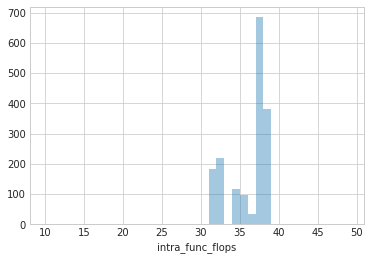

In [3]:
big_exp_results = pickle.load(open("big.pickle", 'rb'))
big_results_df = flops_benchmark.results_to_dataframe(big_exp_results)
sns.distplot(big_results_df.intra_func_flops/1e9, bins=np.arange(10, 50), kde=False)

In [26]:
est_total_flops = big_results_df['est_flops']
total_jobs = len(big_results_df)
JOB_GFLOPS = est_total_flops /1e9 /total_jobs 

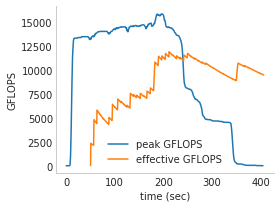

In [27]:
# grid jobs running time 

time_offset = np.min(big_results_df.host_submit_time)
max_time = np.max(big_results_df.download_output_timestamp ) - time_offset
runtime_bins = np.linspace(0, max_time, np.int(max_time), endpoint=False)

runtime_flops_hist = np.zeros((len(big_results_df), len(runtime_bins)))
for i in range(len(big_results_df)):
    row = big_results_df.iloc[i]
    s = (row.start_time + row.setup_time) - time_offset
    e = row.end_time - time_offset
    a, b = np.searchsorted(runtime_bins, [s, e])
    if b-a > 0:
        runtime_flops_hist[i, a:b] = row.est_flops / float(b-a)
        
results_by_endtime = big_results_df.sort_values('download_output_timestamp')
results_by_endtime['job_endtime_zeroed'] = big_results_df.download_output_timestamp - time_offset
results_by_endtime['flops_done'] = results_by_endtime.est_flops.cumsum()
results_by_endtime['rolling_flops_rate'] = results_by_endtime.flops_done/results_by_endtime.job_endtime_zeroed

fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(runtime_flops_hist.sum(axis=0)/1e9, label='peak GFLOPS')
ax.plot(results_by_endtime.job_endtime_zeroed, 
        results_by_endtime.rolling_flops_rate/1e9, label='effective GFLOPS')
ax.set_xlabel('time (sec)')
ax.set_ylabel("GFLOPS")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()
fig.savefig("flops_benchmark.gflops.png")
fig.savefig("flops_benchmark.gflops.pdf")

This plot computes two things:
* **Peak GLFOPS**: Across all cores, what is the total simultaneous FLOPS that are being computed? 
* **Effective GFLOPS**: If the job ended at this point in time, what would our aggregate effective GFLOPS have been, including time to launch the jobs and download the results

We see "peak GFLOPS" peaks in the middle of the job, when all 2800 lambdas are running at once. "Effective GFLOPS" starts climbing as results quickly return, but stragglers mean that in reality our total effective GFLOPS for the job is only ~20GFLOPS. Still not bad for pure python! 